# Assignment - ViT

Here, you implement a model named "vision transformer (ViT)" [1]. Vision transformer is a popular work applying transformer network to vision task. Following step by step, build architecture of ViT, and measure the performance on MNIST dataset.
     
     
ViT is mainly composed of three parts, (1) patch embedding, (2) encoder, (3) and classification head. The encoder module, especially, exploits multi-head attention layer, which you have probably studied before. The overall architecture is depicted below.
      
     
You have to complete code for ToDo (1) image_embedding module (2) transformer encoder and (3) overall architecture. Also, you can train the model with MNIST dataset, and visualize the attention map.
      
     
[1] Alexey Dosovitskiy et. al., An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale, ICLR 2019


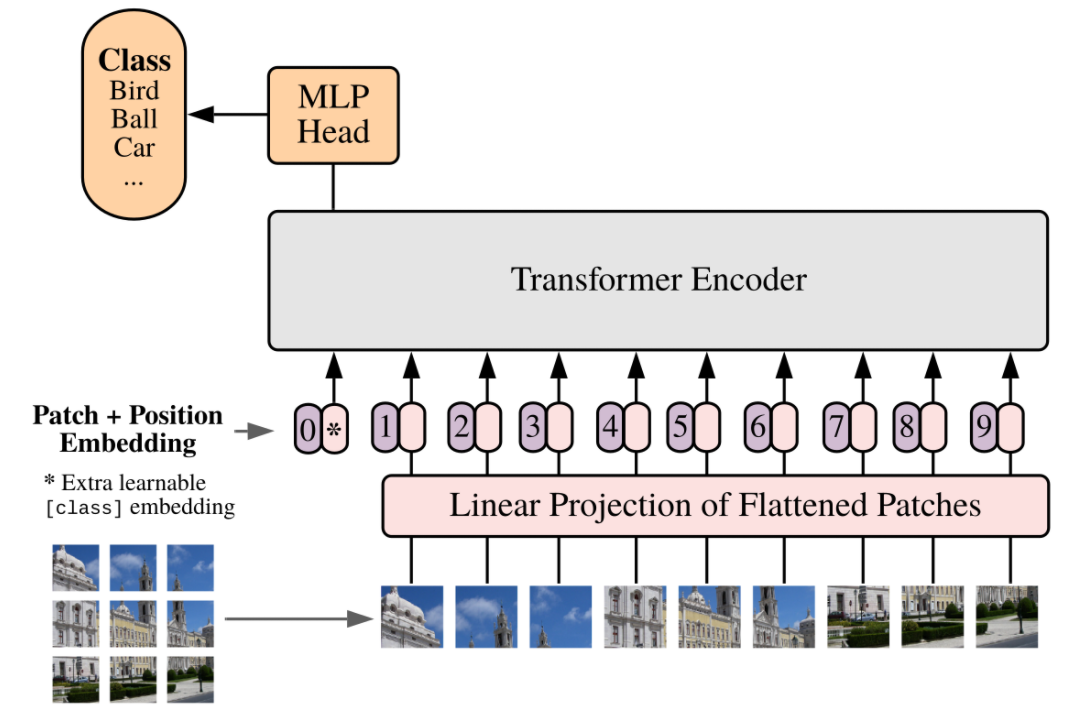

## Modules

In [2]:
import torch
import torch.nn as nn
from torch import Tensor
from torchsummary import summary

import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import numpy as np
import os
import copy
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.long

# reference & tutorial : http://einops.rocks/pytorch-examples.html
%pip install einops
from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange, Reduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# MNIST Dataset

In [3]:
transform = T.Compose([
                T.ToTensor()
            ])

dataset_train = dset.MNIST('dataset', train=True, download=True, transform=transform)
dataset_test = dset.MNIST('dataset', train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



torch.Size([1, 1, 28, 28])

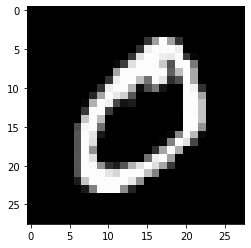

In [15]:
x = dataset_train[1][0]

plt.imshow( x[0], cmap='gray' )
x = x.unsqueeze(0) # add batch dim
x.size()

## Image(Patch) embedding

(ToDo1) Implement image patch embedding module. You divide the image into patches, and attach the class token with positional embeddings.

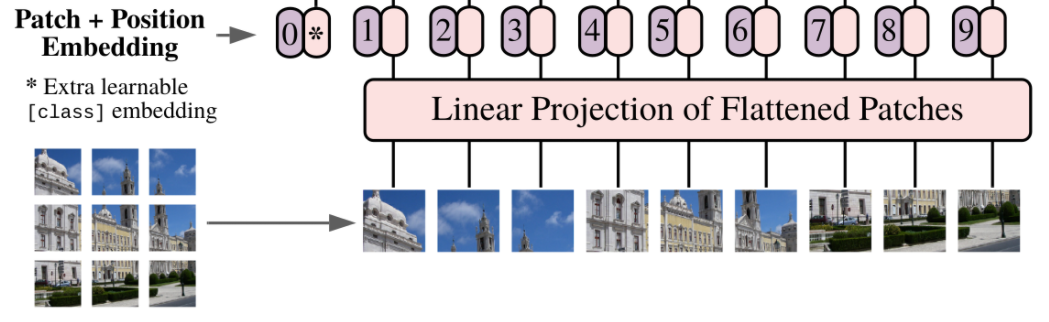

According to the paper, "To handle 2D images, reshape the image $x \in R^{[H \times  W \times C]}$ into a sequence of flattened 2D patches $x_p \in R^{[N \times P^2 * C]}$ where $(H,W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N = H \times W/P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we
flatten the patches and map to $D$ dimensions with a trainable linear projection."

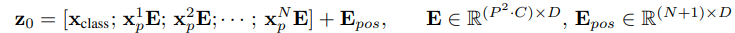

In [16]:
class image_embedding(nn.Module):
  def __init__(self, in_channels: int = 3, img_size: int = 224, patch_size: int = 16, emb_dim: int = 16*16*3):
    super().__init__()

    self.rearrange = Rearrange('b c (num_w p1) (num_h p2) -> b (num_w num_h) (p1 p2 c) ', p1=patch_size, p2=patch_size)
    self.linear = nn.Linear(in_channels * patch_size * patch_size, emb_dim) # sample에서는 16 -> 16으로

    self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
    
    n_patches = img_size * img_size // patch_size**2
    self.positions = nn.Parameter(torch.randn(n_patches + 1, emb_dim))

  def forward(self, x):
    batch, channel, width, height = x.shape
    x = self.rearrange(x) # flatten patches 
    x = self.linear(x) # embedded patches 

    # ================ ToDo1 ================ #
    # (1) Build [token; image embedding] by concatenating class token with image embedding
    c = repeat(self.cls_token, '() n d -> b n d', b=batch)
    x = torch.cat( (c, x), dim=1 )

    # (2) Add positional embedding to [token; image embedding]
    x = x + self.positions
    # ======================================= #
    return x

emb = image_embedding(1, 28, 4, 4*4)(x)
emb.shape
# image_embedding's max sequence = 49([CLS])

torch.Size([1, 50, 16])

## Encoder


#### Multi-Headed Attention

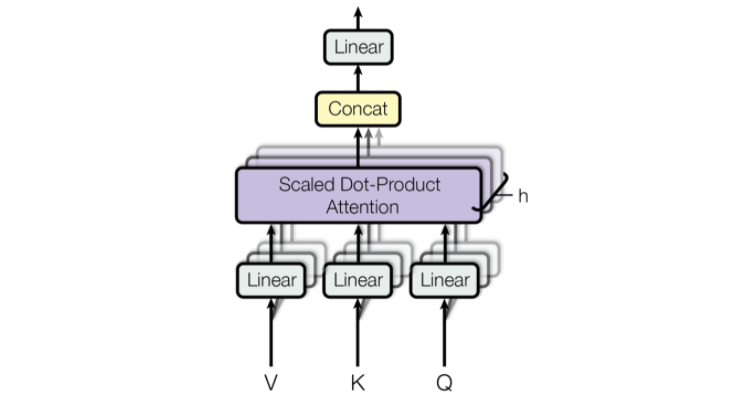

In [17]:
class multi_head_attention(nn.Module):
    def __init__(self, emb_dim: int = 16*16*3, num_heads: int = 8, dropout_ratio: float = 0.2, verbose = False, **kwargs):
        super().__init__()
        self.v = verbose

        self.emb_dim = emb_dim 
        self.num_heads = num_heads 
        self.scaling = (self.emb_dim // num_heads) ** -0.5
        
        self.value = nn.Linear(emb_dim, emb_dim)
        self.key = nn.Linear(emb_dim, emb_dim)
        self.query = nn.Linear(emb_dim, emb_dim)
        self.att_drop = nn.Dropout(dropout_ratio)

        self.linear = nn.Linear(emb_dim, emb_dim)
                
    def forward(self, x: Tensor) -> Tensor:
        # query, key, value
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        if self.v: print(Q.size(), K.size(), V.size()) 

        # q = k = v = patch_size**2 + 1 & h * d = emb_dim
        Q = rearrange(Q, 'b q (h d) -> b h q d', h=self.num_heads)
        K = rearrange(K, 'b k (h d) -> b h d k', h=self.num_heads)
        V = rearrange(V, 'b v (h d) -> b h v d', h=self.num_heads)
        if self.v: print(Q.size(), K.size(), V.size()) 

        ## scaled dot-product
        weight = torch.matmul(Q, K) 
        weight = weight * self.scaling
        if self.v: print(weight.size()) 
        
        attention = torch.softmax(weight, dim=-1)
        attention = self.att_drop(attention) 
        if self.v: print(attention.size())

        context = torch.matmul(attention, V) 
        context = rearrange(context, 'b h q d -> b q (h d)')
        if self.v: print(context.size())

        x = self.linear(context)
        return x , attention

feat, att = multi_head_attention(4*4, 4, verbose=True)(emb)
feat.shape, att.shape

torch.Size([1, 50, 16]) torch.Size([1, 50, 16]) torch.Size([1, 50, 16])
torch.Size([1, 4, 50, 4]) torch.Size([1, 4, 4, 50]) torch.Size([1, 4, 50, 4])
torch.Size([1, 4, 50, 50])
torch.Size([1, 4, 50, 50])
torch.Size([1, 50, 16])


(torch.Size([1, 50, 16]), torch.Size([1, 4, 50, 50]))

#### MLP block

In [18]:
class mlp_block(nn.Module):
    def __init__(self, emb_dim: int = 16*16*3, forward_dim: int = 4, dropout_ratio: float = 0.2, **kwargs):
        super().__init__()
        self.linear_1 = nn.Linear(emb_dim, forward_dim * emb_dim) # 768 -> 768 * 4 -> 768 Bottle Neck
        self.dropout = nn.Dropout(dropout_ratio)
        self.linear_2 = nn.Linear(forward_dim * emb_dim, emb_dim)
        
    def forward(self, x):
        x = self.linear_1(x)
        x = nn.functional.gelu(x)
        x = self.dropout(x) 
        x = self.linear_2(x)
        return x

#### Transformer Encoder

(ToDo2) Design the forward pass by observing the architecture of encoder.

According to the original paper, "The Transformer encoder[2] consists of alternating layers of multiheaded selfattention (MSA, which is also MHA) and MLP blocks.
        
[2] Vaswani et al., "Attention is all you need", NIPS 2017

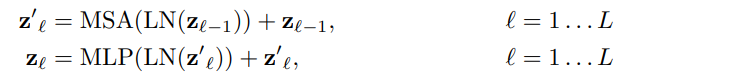

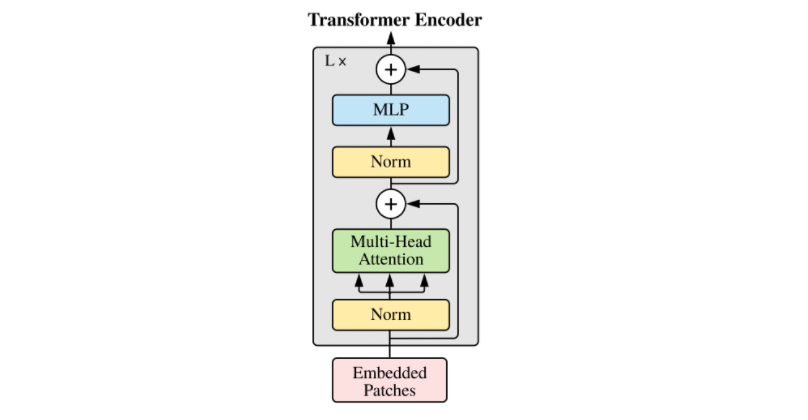

In [19]:
class encoder_block(nn.Sequential):
    def __init__(self, emb_dim:int = 16*16*3, num_heads:int = 8, forward_dim: int = 4, dropout_ratio:float = 0.2):
        super().__init__()

        self.norm_1 = nn.LayerNorm(emb_dim)
        self.mha = multi_head_attention(emb_dim, num_heads, dropout_ratio)

        self.norm_2 = nn.LayerNorm(emb_dim)
        self.mlp = mlp_block(emb_dim, forward_dim, dropout_ratio)

    def forward(self, x):
        # ================ ToDo2 ================ #
         input = x
         x = self.norm_1(x)
         x, attention = self.mha (x)
         x = x + input

        # x_L = normalize(x)
        # x_L = mlp(x_L)
        # x  = x_L + residual(x)
        # ======================================= #
         return x, attention
        
feat, att = encoder_block(4*4, 2, 4)(emb)
feat.shape, att.shape

(torch.Size([1, 50, 16]), torch.Size([1, 2, 50, 50]))

## Model

(ToDo3) Design the overall architecture for ViT by using modules implemented above.

According to the original paper, "A classification head is attached to $z_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training
time and by a single linear layer at fine-tuning time."

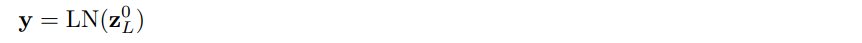

In [21]:
class vision_transformer(nn.Module):
    """ Vision Transformer model
    classifying input images (x) into classes
    """
    def __init__(self, in_channel: int = 3, img_size:int = 224, 
                 patch_size: int = 16, emb_dim:int = 16*16*3, 
                 n_enc_layers:int = 15, num_heads:int = 3, 
                 forward_dim:int = 4, dropout_ratio: float = 0.2, 
                 n_classes:int = 1000):
        super().__init__()


        # ================ ToDo3 ================ #
        # You need (1) image embedding module & (2) encoder module
        self.embeding_module = image_embedding(1, 28, 4, 16)
        self.encoder_module = nn.ModuleList( [ encoder_block( 16, 2, 4 ) for _ in range(n_enc_layers)] )
        # ======================================= #      

        self.normalization = nn.LayerNorm(emb_dim)
        self.classification_head = nn.Linear(emb_dim, n_classes) 

    def forward(self, x):
        # ================ ToDo3 ================ #
        x = self.embeding_module(x)

        # (2) transformer_encoder
        attentions = []
        for enc in self.encoder_module:
          x, att = enc(x)
          attentions.append(att)
          
        # ======================================= #

        x = x[:, 0, :] # cls_token output
        x = self.normalization(x)
        x = self.classification_head(x)

        return x, attentions

y, att = vision_transformer(1, 28, 4, 4*4, 3, 2, 4, 0.2, 10)(x)
y.shape, att[0].shape

torch.Size([1, 1, 28, 28])


(torch.Size([1, 10]), torch.Size([1, 2, 50, 50]))

## Performance

In [22]:
model = vision_transformer(1, 28, 4, 4*4, 3, 2, 4, 0.2, 10)
model.to(device)

num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

batch_size = 64
dataloaders_train = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(0, len(dataset_train) * 4//5)))
dataloaders_valid = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(len(dataset_train) * 4//5, len(dataset_train))))
dataloaders_test = DataLoader(dataset_test, batch_size=batch_size)

In [23]:
for epoch in range(num_epochs):
    print('*** Epoch {} ***'.format(epoch))

    # Training
    model.train()  
    running_loss, running_acc = 0.0, 0.0
        
    for idx, (inputs, labels) in enumerate(dataloaders_train):
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      with torch.set_grad_enabled(True):
        outputs, _ = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.shape[0]
        running_acc += torch.sum(preds == labels.data)
    running_acc /= (idx+1) * batch_size
    print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', running_loss, running_acc))

    # Validation
    model.eval()  
    running_acc = 0.0
        
    for idx, (inputs, labels) in enumerate(dataloaders_valid):
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.set_grad_enabled(False):
        outputs, _ = model(inputs)
        _, preds = torch.max(outputs, 1)

        # statistics
        running_acc += torch.sum(preds == labels.data)
    running_acc /= (idx+1) * batch_size
    print('{} Acc: {:.4f}\n'.format('valid', running_acc))

*** Epoch 0 ***
train Loss: 65211.4352 Acc: 0.5392
valid Acc: 0.8318

*** Epoch 1 ***
train Loss: 29311.6089 Acc: 0.8094
valid Acc: 0.8784

*** Epoch 2 ***
train Loss: 23018.2096 Acc: 0.8517
valid Acc: 0.9003

*** Epoch 3 ***
train Loss: 20084.9663 Acc: 0.8704
valid Acc: 0.9128

*** Epoch 4 ***
train Loss: 18270.0836 Acc: 0.8842
valid Acc: 0.9195

*** Epoch 5 ***
train Loss: 16636.2661 Acc: 0.8932
valid Acc: 0.9263

*** Epoch 6 ***
train Loss: 15471.5223 Acc: 0.9018
valid Acc: 0.9320

*** Epoch 7 ***
train Loss: 14762.1773 Acc: 0.9075
valid Acc: 0.9334

*** Epoch 8 ***
train Loss: 13992.5769 Acc: 0.9105
valid Acc: 0.9400

*** Epoch 9 ***
train Loss: 13279.5542 Acc: 0.9146
valid Acc: 0.9412



In [24]:
model.eval()  
running_acc = 0.0
    
for idx, (inputs, labels) in enumerate(dataloaders_test):
  inputs = inputs.to(device)
  labels = labels.to(device)

  with torch.set_grad_enabled(False):
    outputs, _ = model(inputs)
    _, preds = torch.max(outputs, 1)

    # statistics
    running_acc += torch.sum(preds == labels.data)
running_acc /= (idx+1) * batch_size
print('{} Acc: {:.4f}\n'.format('test', running_acc))

test Acc: 0.9372



#### Visualization

ref : https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb

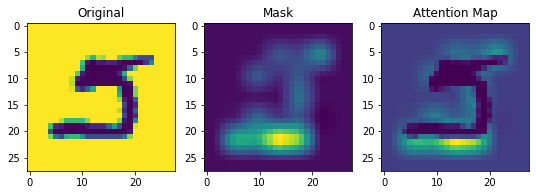

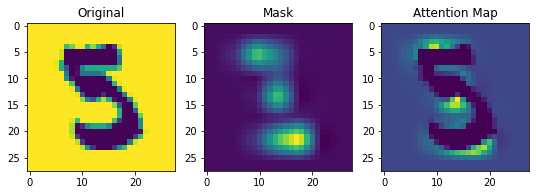

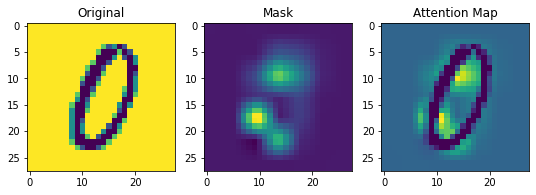

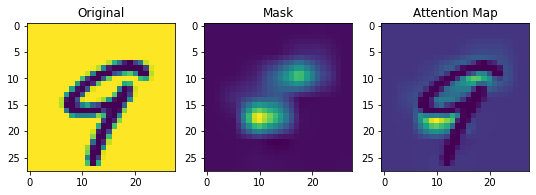

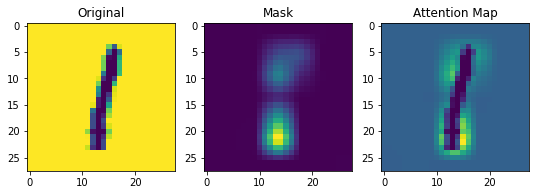

In [25]:
idxs = np.random.choice(range(len(dataset_test.data)), 5, False)
for idx in idxs:
  img = dataset_test.data[idx]
  img = 255 - img 

  _, attentions = model(img.unsqueeze(0).unsqueeze(1).to(device, torch.float))

  # Average the attention weights across all heads.
  att_mat = torch.stack(attentions).squeeze(1)
  att_mat = att_mat.cpu().detach()
  att_mat = reduce(att_mat, 'b h len1 len2 -> b len1 len2', 'mean')

  residual_att = torch.eye(att_mat.size(1))
  aug_att_mat = att_mat + residual_att
  aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

  # Recursively multiply the weight matrices
  joint_attentions = torch.zeros(aug_att_mat.size())
  joint_attentions[0] = aug_att_mat[0]

  for n in range(1, aug_att_mat.size(0)):
      joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
      
  # Attention from the output token to the input space.
  v = joint_attentions[-1]
  grid_size = int(np.sqrt(aug_att_mat.size(-1)))
  mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
  mask = cv2.resize(mask / mask.max(), (img.shape[1], img.shape[0]))[..., np.newaxis]
  mask = mask.squeeze()
  result = (mask * img.numpy()).astype("uint8")

  # plotting
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(9, 3)) 
  ax1.set_title('Original')
  ax2.set_title('Mask')
  ax3.set_title('Attention Map')
  _ = ax1.imshow(img)
  _ = ax2.imshow(mask)
  _ = ax3.imshow(result)